In [4]:
%cd /mnt/home/alamson/ceph/DATA/CRISPR/crispr_kinn

/mnt/ceph/users/alamson/DATA/CRISPR/crispr_kinn


In [5]:
import numpy as np
import pandas as pd
from Bio import pairwise2
from Bio.Seq import Seq
from sklearn.preprocessing import scale
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [6]:
# pre-defined letter index
build_indel = False
# match : 4 letters, 0-3
ltidx = {(x,x):i for i,x in enumerate('ACGT')}
# substitution : x->y, 4-7
ltidx.update({(x,y):(ltidx[(x,x)], i+4) for x in 'ACGT' for i, y in enumerate('ACGT') if y!=x })
if build_indel:
    # insertion : NA->y, 8-11
    ltidx.update({('-', x):i+8 for i,x in enumerate('ACGT')})
    # deletion : x->NA, 12
    ltidx.update({(x,'-'):(ltidx[(x,x)], 12) for i,x in enumerate('ACGT')})
ltidx

{('A', 'A'): 0,
 ('C', 'C'): 1,
 ('G', 'G'): 2,
 ('T', 'T'): 3,
 ('A', 'C'): (0, 5),
 ('A', 'G'): (0, 6),
 ('A', 'T'): (0, 7),
 ('C', 'A'): (1, 4),
 ('C', 'G'): (1, 6),
 ('C', 'T'): (1, 7),
 ('G', 'A'): (2, 4),
 ('G', 'C'): (2, 5),
 ('G', 'T'): (2, 7),
 ('T', 'A'): (3, 4),
 ('T', 'C'): (3, 5),
 ('T', 'G'): (3, 6)}

In [7]:
def make_alignment(df, maxlen=25):
    ref = Seq(df.iloc[0]['sequence'])
    ref = ref[::-1]
    alignments = []
    for seq in df['sequence']:
        alt = Seq(seq)
        alt = alt[::-1]
        # m: A match score is the score of identical chars, otherwise mismatch score
        # d: The sequences have different open and extend gap penalties.
        aln = pairwise2.align.localxd(ref, alt, -1, -0.1, -1, 0)
        if len(aln[0][0]) > maxlen: # increase gap open penalty to avoid too many gaps
            aln = pairwise2.align.localxd(ref, alt, -5, -0.1, -5, 0)
            if len(aln[0][0]) > maxlen:
                aln = [(ref, alt)]
        alignments.append(aln[0])
    return alignments


def featurize_alignment(alignments, maxlen=25, verbose=False):
    mats = []
    for j, aln in enumerate(alignments):
        if build_indel:
            fea = np.zeros((maxlen, 13))
        else:
            fea = np.zeros((maxlen, 8))
            
        assert len(aln[0]) <= maxlen, "alignment {} larger than maxlen: {}".format(j, aln)
        if build_indel is False and ('-' in aln[0] or '-' in aln[1]):
            mats.append(None)
        else:
            p = 0
            for i in range(len(aln[0])):
                k = (aln[0][i], aln[1][i])
                fea[p, ltidx[k]] = 1
                p += 1
                #if k[0]=="-" or k[1]=="-": # is indel
                #    if build_indel:
                #        fea[p, ltidx[k]] = 1
                #        p += 1
                    #elif k[1]=="-": # target has gap - deletion
                    #    fea[p, ltidx[k]] = 1
                    #    p += 1
                    #else:           # gRNA has gap - insertion
                    #    fea[max(0,p-1), ltidx[k]] = 1
                #else:
                #    fea[p, ltidx[k]] = 1
                #    p += 1
                if verbose: print(k, p)
            mats.append(fea)
    return mats

def get_cleavage_specificity(df, label_cols):
    k_m = df.query('descriptor=="Matched"')[label_cols].to_numpy()
    df[['%s_specificity'%x for x in label_cols]] = k_m - df[label_cols]
    return df

In [8]:
#featurize_alignment([alns1[112]], verbose=True)
#featurize_alignment([alns1[72]], verbose=True)

In [16]:
# read
df1 = pd.read_csv("./data/sgRNA_1.csv")
#df2 = pd.read_csv("./data/sgRNA_2.csv")
df1 = df1.dropna()
#df2 = df2.dropna()

print("df1", df1.shape)
#print("df2", df2.shape)

aba_cols = ['wtCas9_ndABA', 
    'Cas9_enh_ndABA',
    'Cas9_hypa_ndABA', 
    'Cas9_HF1_ndABA', ]
cl_cols = ['wtCas9_cleave_rate_log',
    'Cas9_enh_cleave_rate_log',
    'Cas9_hypa_cleave_rate_log',
    'Cas9_HF1_cleave_rate_log',
]

# THIS IS IMPORTANT: df1 cleave rates seems to be non-negative, thus must be non-log
print("df1\n", df1[cl_cols].min())
#print("df2\n", df2[cl_cols].min())
df1[cl_cols] = np.log10(df1[cl_cols])
print("df1, after log10\n", df1[cl_cols].min())

# clip at limit of detection
LOD = 1e-5
df1[cl_cols] = np.maximum(df1[cl_cols], np.log10(LOD))
#df2[cl_cols] = np.maximum(df2[cl_cols], np.log10(LOD))
LOD = 1e-1
df1[cl_cols] = np.minimum(df1[cl_cols], np.log10(LOD))
#df2[cl_cols] = np.minimum(df2[cl_cols], np.log10(LOD))


df1 = get_cleavage_specificity(df1, cl_cols)
#df2 = get_cleavage_specificity(df2, cl_cols)

# convert
alns1 = make_alignment(df1)
#alns2 = make_alignment(df2)
mats1 = featurize_alignment(alns1)
#mats2 = featurize_alignment(alns2)

val_idx1 = [i for i in range(len(mats1)) if mats1[i] is not None]
#val_idx2 = [i for i in range(len(mats2)) if mats2[i] is not None]

label_cols = cl_cols + ['%s_specificity'%x for x in cl_cols] + aba_cols
label1 = df1[label_cols].to_numpy()[val_idx1]
#label2 = df2[label_cols].to_numpy()[val_idx2]

mats = np.array([mats1[i] for i in val_idx1])
#mats = np.concatenate([np.array([mats1[i] for i in val_idx1]), np.array([mats2[i] for i in  val_idx2])])
labels = label1
#labels = np.concatenate([label1, label2])

# sanity check
if not build_indel:
    for i in range(len(mats)):
        assert sum(mats[i][-1]) == 0, i
        assert sum(mats[i][-2]) == 0, i
    #mats = mats[:, 0:23, :]

print(mats.shape)
print(labels.shape)

# save
np.save("data/compiled_sgRNA1_X.npy", mats)
np.save("data/compiled_sgRNA1_Y.npy", labels)
with open("data/x_col_annot.txt", 'w') as f:
    f.write("\n".join([str(x) for x in ltidx]))

with open("data/y_col_annot.txt", 'w') as f:
    f.write("\n".join(label_cols))
                                    

df1 (6988, 18)
df1
 wtCas9_cleave_rate_log       4.940656e-324
Cas9_enh_cleave_rate_log      2.118523e-33
Cas9_hypa_cleave_rate_log    4.940656e-324
Cas9_HF1_cleave_rate_log     4.940656e-324
dtype: float64
df1, after log10
 wtCas9_cleave_rate_log      -323.306215
Cas9_enh_cleave_rate_log     -32.673967
Cas9_hypa_cleave_rate_log   -323.306215
Cas9_HF1_cleave_rate_log    -323.306215
dtype: float64
(2488, 25, 8)
(2488, 12)


In [10]:
df1.iloc[90]

sequence                                 AGACGCATAAAGATGAGACGCTGG
descriptor                                                  21A20
wtCas9_ndABA                                           -0.0123935
wtCas9_ndABA_unc                                        0.0130876
wtCas9_cleave_rate_log                                         -1
wtCas9_cleave_rate_log_unc                              0.0700477
Cas9_enh_ndABA                                         -0.0208602
Cas9_enh_ndABA_unc                                      0.0119353
Cas9_enh_cleave_rate_log                                 -1.02146
Cas9_enh_cleave_rate_log_unc                            0.0724216
Cas9_hypa_ndABA                                        -0.0116447
Cas9_hypa_ndABA_unc                                     0.0250457
Cas9_hypa_cleave_rate_log                                      -1
Cas9_hypa_cleave_rate_log_unc                           0.0659332
Cas9_HF1_ndABA                                         -0.0110754
Cas9_HF1_n

In [11]:
mats[90]

array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 

In [13]:
# feat = 'wtCas9_ndABA'
# ax = sns.scatterplot(
#     np.percentile(df1[feat], np.arange(5,95,1)),
#     np.percentile(df2[feat], np.arange(5,95,1)),
# )
# ax.set_title(feat)
# ax.set_xlabel('sgRNA 1')
# ax.set_ylabel('sgRNA 2')

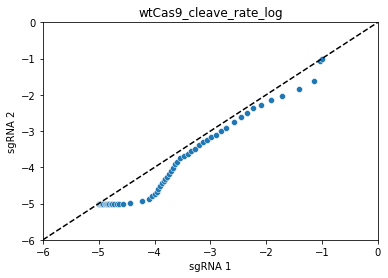

In [10]:
# feat = 'wtCas9_cleave_rate_log'
# ax = sns.scatterplot(
#     np.percentile(df1[feat], np.arange(1,99,1)),
#     np.percentile(df2[feat], np.arange(1,99,1)),
# )
# ax.set_title(feat)
# ax.set_xlabel('sgRNA 1')
# ax.set_ylabel('sgRNA 2')
# ax.set_xlim(np.log10(LOD)-5, 0)
# ax.set_ylim(np.log10(LOD)-5, 0)
# ax.plot([0,1],[0,1], transform=ax.transAxes, ls='--', color='black')

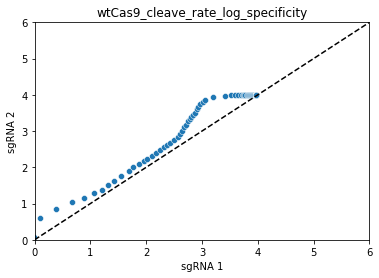

In [11]:
# feat = 'wtCas9_cleave_rate_log_specificity'
# ax = sns.scatterplot(
#     np.percentile(df1[feat], np.arange(1,99,1)),
#     np.percentile(df2[feat], np.arange(1,99,1)),
# )
# ax.set_title(feat)
# ax.set_xlabel('sgRNA 1')
# ax.set_ylabel('sgRNA 2')
# ax.set_xlim(0, -np.log10(LOD)+5)
# ax.set_ylim(0, -np.log10(LOD)+5)
# ax.plot([0,1],[0,1], transform=ax.transAxes, ls='--', color='black')

# Visualization alignments

In [12]:
alns1[100]

Alignment(seqA='GGTCGCAGAGTAGAAA-TACGCAG', seqB='GGTCGCAGAGTAGAAAATACGCAG', score=22.0, start=0, end=24)

In [13]:
# alns2[100]

Alignment(seqA='GGTGTACCGTAAG-GTGAATAGTG', seqB='GGTGTACCGTAAGAGTGAATAGTG', score=22.0, start=0, end=24)

In [14]:
# modified from 
# https://dmnfarrell.github.io/bioinformatics/bokeh-sequence-aligner

import os, io, random
import string
import numpy as np

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot

def get_colors(seqs):
    """make colors for bases in sequence"""
    text = [i for s in list(seqs) for i in s]
    clrs =  {'A':'red','T':'green','G':'orange','C':'blue','-':'white'}
    colors = [clrs[i] for i in text]
    return colors


def view_alignment(aln, fontsize="9pt", plot_width=800):
    """Bokeh sequence alignment view"""

    #make sequence and id lists from the aln object
    seqs = aln[0:2]
    ids = ["gRNA", "target"]    
    text = [i for s in list(seqs) for i in s]
    colors = get_colors(seqs)    
    N = len(seqs[0])
    S = len(seqs)    
    width = .4

    x = np.arange(1,N+1)
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    #use recty for rect coords with an offset
    recty = gy+.5
    h= 1/S
    #now we can create the ColumnDataSource with all the arrays
    source = ColumnDataSource(dict(x=gx, y=gy, recty=recty, text=text, colors=colors))
    plot_height = len(seqs)*15+50
    x_range = Range1d(0,N+1, bounds='auto')
    if N>100:
        viewlen=100
    else:
        viewlen=N
    #view_range is for the close up view
    view_range = (0,viewlen)
    tools="xpan, xwheel_zoom, reset, save"

    #entire sequence view (no text, with zoom)
    p = figure(title=None, plot_width= plot_width, plot_height=50,
               x_range=x_range, y_range=(0,S), tools=tools,
               min_border=0, toolbar_location='below')
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                 line_color=None, fill_alpha=0.6)
    p.add_glyph(source, rects)
    p.yaxis.visible = False
    p.grid.visible = False  

    #sequence text view with ability to scroll along x axis
    p1 = figure(title=None, plot_width=plot_width, plot_height=plot_height,
                x_range=view_range, y_range=ids, tools="xpan,reset",
                min_border=0, toolbar_location='below')#, lod_factor=1)          
    glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black",
                text_font="monospace",text_font_size=fontsize)
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                line_color=None, fill_alpha=0.4)
    p1.add_glyph(source, glyph)
    p1.add_glyph(source, rects)

    p1.grid.visible = False
    p1.xaxis.major_label_text_font_style = "bold"
    p1.yaxis.minor_tick_line_width = 0
    p1.yaxis.major_tick_line_width = 0

    p = gridplot([[p],[p1]], toolbar_location='below')
    return p

ModuleNotFoundError: No module named 'panel'

In [15]:
print(df2.iloc[99])
p = view_alignment(alns2[99], plot_width=300)
pn.pane.Bokeh(p)

sequence                                 GTGATAAGTAGGAATGCCATGTGG
descriptor                                                  12A11
wtCas9_ndABA                                             0.409341
wtCas9_ndABA_unc                                         0.030304
wtCas9_cleave_rate_log                                  -2.334041
wtCas9_cleave_rate_log_unc                               0.114384
Cas9_enh_ndABA                                           0.295856
Cas9_enh_ndABA_unc                                        0.04959
Cas9_enh_cleave_rate_log                                     -5.0
Cas9_enh_cleave_rate_log_unc                              7.40744
Cas9_hypa_ndABA                                          0.133974
Cas9_hypa_ndABA_unc                                       0.01357
Cas9_hypa_cleave_rate_log                                    -5.0
Cas9_hypa_cleave_rate_log_unc                            0.081112
Cas9_HF1_ndABA                                           0.387882
Cas9_HF1_n

Bokeh(Column)

In [16]:
p = view_alignment(alns1[100], plot_width=300)
pn.pane.Bokeh(p)

Bokeh(Column)

In [15]:
try:
    for i in range(len(mats1[100])):
        print((i, mats1[100][i]))
except:
    pass